# Cas Kaggle

Josep Maria Domingo Catafal, NIU: 1599946

## Introduction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration

The first step we need to take is looking into our data. What values does it contain? What do they tell us? If we take a look at the atributes of our dataset we see the following:

| Feature | Type | Description |
|:---|:---|:---
| id | int | The product ID at Sephora's website |
| brand | object | The brand of the product at Sephora's website |
| category | Object | The category of the product at Sephora's website |
| name | Object | The name of the product at Sephora's website |
| size | Object | The size of the product |
| rating | float | The rating of the product |
| numberofreviews | int | The number of reviews of the product |
| love | int | The number of people loving the product |
| price | float | The price of the product |
| value_price |	float | The value price of the product (for discounted products) |
| URL | object | The URL link of the product |
| MarketingFlags | bool | The Marketing Flags of the product from the website if they were exclusive or sold online only |
| MarketingFlags_content | 	object | The kinds of Marketing Flags of the product |
| options | object | The options available on the website for the product like colors and sizes|
| details | object | Details of the product available on the website |
| howtouse | object | The instructions of the product if available |
| ingredients | object | The ingredients of the product if available |
| online_only | int | If the product is sold online only |
| exclusive | int | If the product is sold exclusively on Sephora's website |
| limited_edition | int | If the product is limited edition |
| limitedtimeoffer | int | The product has a limited time offer |


Most of this attributes are propertiers of the product in hand, but there's a few that are opinions given by the users of the website. Now we are goinng to load the dataset to analyze the data with a bit more detail.

In [62]:
df = pd.read_csv("data/sephora_website_dataset.csv").drop("URL", axis=1)
df.head(1)

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0


In [37]:
print(f"There are {df.shape[0]} products with {df.shape[1]} attributes each")

There are 9168 products with 20 attributes each


Now we check how many NULL values we have in our dataset.

In [38]:
df.isnull().sum()

id                        0
brand                     0
category                  0
name                      0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64

As we can see there are no NULL values in the dataset. This is great because it means we have more data to work with, plus we don't have to do any preprocessing to treat the NULL values.

After looking at the dataset, it seems iteresting trying to **predict the number of people that love a product**. This way, when we want to develop a new product we can predict beforehand if it will be successful or not. Now we will analyze the data in order to find patterns that will help us predict said value.

# Data Analysis

In [48]:
df.describe(include=[np.number]).drop("count").T.style.background_gradient(cmap='plasma')

,mean,std,min,25%,50%,75%,max
id,1962951.784795,385971.360901,50.000000,1819453.000000,2072353.500000,2230591.000000,2359685.000000
rating,3.990020,1.007707,0.000000,4.000000,4.000000,4.500000,5.000000
number_of_reviews,282.139180,890.642028,0.000000,10.000000,46.000000,210.000000,19000.000000
love,16278.585079,42606.514471,0.000000,1600.000000,4800.000000,13800.000000,1300000.000000
price,50.063237,47.164989,2.000000,24.000000,35.000000,59.000000,549.000000
value_price,51.823590,49.459020,2.000000,25.000000,35.000000,60.000000,549.000000
online_only,0.234839,0.423921,0.000000,0.000000,0.000000,0.000000,1.000000
exclusive,0.264725,0.441211,0.000000,0.000000,0.000000,1.000000,1.000000
limited_edition,0.091841,0.288817,0.000000,0.000000,0.000000,0.000000,1.000000
limited_time_offer,0.000327,0.018087,0.000000,0.000000,0.000000,0.000000,1.000000


In [43]:
df.describe(exclude=[np.number]).drop("count").T

,unique,top,freq
brand,324,SEPHORA COLLECTION,496
category,143,Perfume,665
name,9106,Blush,4
size,1623,no size,3161
MarketingFlags,2,False,4786
MarketingFlags_content,10,0,4786
options,564,no options,8377
details,8839,no details,14
how_to_use,6497,no instructions,1573
ingredients,6962,unknown,1630


<AxesSubplot:>

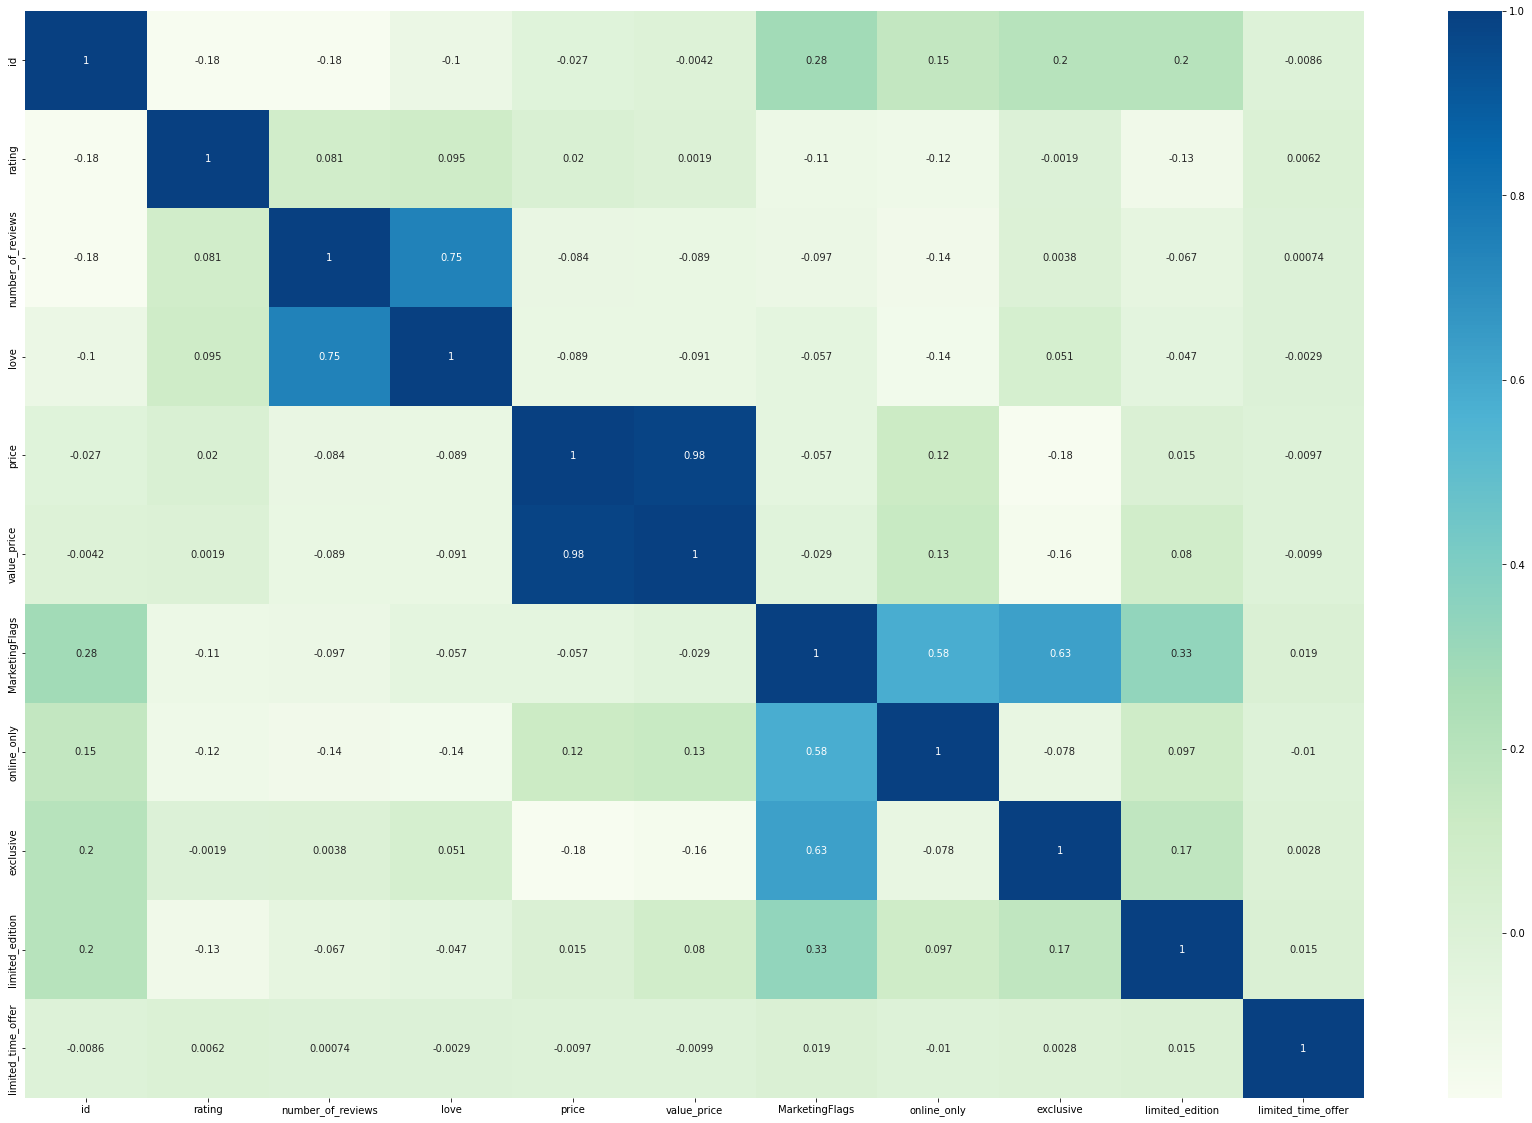

In [60]:
plt.figure(figsize=(30,20))
sns.heatmap(data = df.corr(),cmap='GnBu',annot=True)

There is a very strong correlation between "price" and "value_price", that's because the value price is the same than the price except when the product has recived a discount, in which case the price is a little bit lower.

We can also see a strong correlation between the number of reviews and the number of people that love a product. Let's take a deeper look to see what's going on.

[Text(0, 0.5, 'love'), Text(0.5, 0, 'num. reviews')]

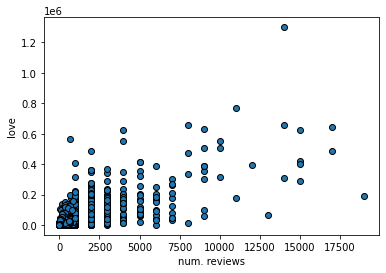

In [73]:
fig, ax = plt.subplots()
plt.scatter(y=df['love'], x=df['number_of_reviews'], edgecolors="black")
ax.set(ylabel="love", xlabel="num. reviews")

We can see that most points are clustered near the (0,0), so this means we are getting such high correlations because most products don't have neither reviews nor love.

Now we will take a look at how price affects the number of people that loves a product.

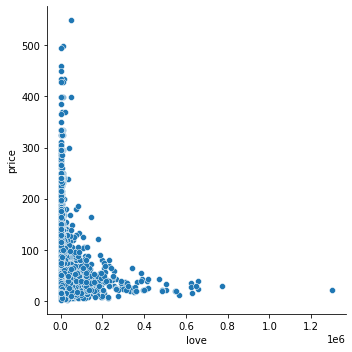

In [78]:
sns.relplot(x='love', y='price', data=df)

We can see that only products under 200 have a lot of people that loves them, beyond that not many people loves them or in most cases no one. If we had to choose a price to get the most love we would set it below 50.

## Aplicació de diversos mètodes d'aprenentatge

## Visualització i presentació dels resultats